importとか諸々

In [18]:
import pandas as pd
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

データの読み込み

In [2]:
test = pd.read_csv('test.csv')
year1 = pd.read_csv('year1.csv')
year2 = pd.read_csv('year2.csv')
year3 = pd.read_csv('year2.csv')
year4 = pd.read_csv('year2.csv')

データをまとめる

In [3]:
all_data = pd.concat([year1,year2,year3,year4])

In [4]:
all_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,id,TARGET
0,0.20055,0.37951,0.39641,2.0472,32.351,0.38825,0.24976,1.3305,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.416,5.1372,82.658,4.4158,7.4277,0,0
1,0.20912,0.49988,0.47225,1.9447,14.786,0,0.25834,0.99601,1.6996,0.49788,...,0.42002,0.853,0,4.1486,3.2732,107.35,3.4,60.987,1,0
2,0.24866,0.69592,0.26713,1.5548,-1.1523,0,0.30906,0.43695,1.309,0.30408,...,0.81774,0.76599,0.69484,4.9909,3.951,134.27,2.7185,5.2078,2,0
3,0.081483,0.30734,0.45879,2.4928,51.952,0.14988,0.092704,1.8661,1.0571,0.57353,...,0.14207,0.94598,0,4.5746,3.6147,86.435,4.2228,5.5497,3,0
4,0.18732,0.61323,0.2296,1.4063,-7.3128,0.18732,0.18732,0.6307,1.1559,0.38677,...,0.48431,0.86515,0.12444,6.3985,4.3158,127.21,2.8692,7.898,4,0


前処理

In [5]:
for i in all_data.iloc[:,0:-2]: 
  all_data[i] = pd.to_numeric(all_data[i],errors='coerce')
all_data = all_data.fillna(all_data.mean())

In [6]:
for i in test.iloc[:,0:-1]:
  test[i] = pd.to_numeric(test[i],errors='coerce')
test = test.fillna(test.mean())


In [7]:
def remove_outliers(df, q=0.005):
    upper = df.quantile(1-q)
    lower = df.quantile(q)
    mask = (df < upper) & (df > lower)
    return mask

mask = remove_outliers(all_data)
all_data.iloc[:,0:-2] = all_data[mask]
mask = remove_outliers(test)
test.iloc[:,0:-1] = test[mask]

all_data = all_data.fillna(all_data.mean())
test = test.fillna(test.mean())

In [8]:
# 取り除く列のリスト
not_use_columns = ['X37']
# 学習用データから列を削除する（PassengerIdは後ほど取り除く）
all_data.drop(not_use_columns, axis=1, inplace=True)
# テスト用データから列を削除する
test.drop(not_use_columns, axis=1, inplace=True)

In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37546 entries, 0 to 10172
Data columns (total 65 columns):
X1        37546 non-null float64
X2        37546 non-null float64
X3        37546 non-null float64
X4        37546 non-null float64
X5        37546 non-null float64
X6        37546 non-null float64
X7        37546 non-null float64
X8        37546 non-null float64
X9        37546 non-null float64
X10       37546 non-null float64
X11       37546 non-null float64
X12       37546 non-null float64
X13       37546 non-null float64
X14       37546 non-null float64
X15       37546 non-null float64
X16       37546 non-null float64
X17       37546 non-null float64
X18       37546 non-null float64
X19       37546 non-null float64
X20       37546 non-null float64
X21       37546 non-null float64
X22       37546 non-null float64
X23       37546 non-null float64
X24       37546 non-null float64
X25       37546 non-null float64
X26       37546 non-null float64
X27       37546 non-null float64


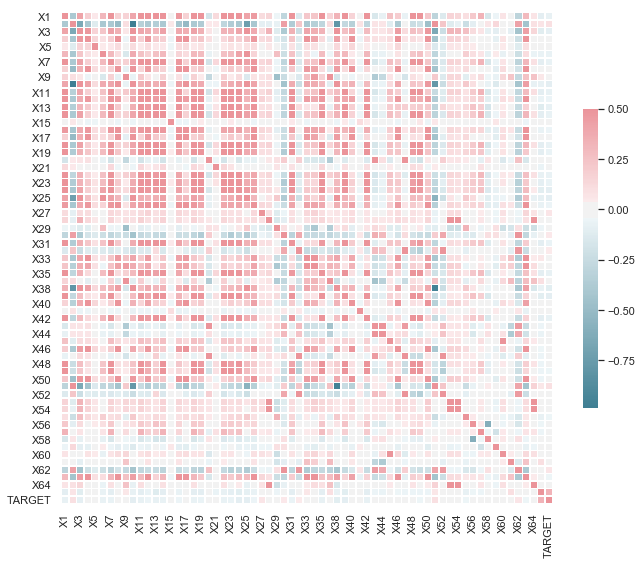

In [10]:
sns.set(style="white")
 
 
# Compute the correlation matrix
corr = all_data.corr()
 
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.show()

Xとyの決定

In [11]:
X = all_data.iloc[:, 0:-2]
test_X = test.iloc[:,0:-1]

In [12]:
y = all_data.loc[:, 'TARGET']

In [13]:
scaler = StandardScaler()
scaler.fit_transform(X)

array([[ 0.77927476, -0.43230794,  0.68053203, ..., -0.12787542,
        -0.3838719 , -0.19033733],
       [ 0.8313373 , -0.04215569,  0.93565198, ...,  0.09138165,
        -0.50355431,  0.7421301 ],
       [ 1.07154184,  0.59326382,  0.245644  , ...,  0.33042265,
        -0.58384921, -0.22898579],
       ...,
       [-0.34737808,  0.14489827, -1.61033348, ...,  0.15265145,
        -0.52773114, -0.27751965],
       [-0.45457832, -0.13654162,  0.77337631, ..., -0.29096852,
        -0.23524092,  0.12254301],
       [-0.42647609,  1.39460418, -1.10621592, ...,  0.84757525,
        -0.68075684, -0.16372615]])

データを分割

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

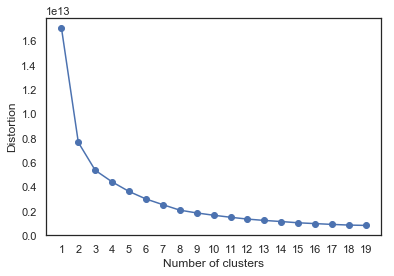

In [49]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components = 20)
X_pca = pca.fit_transform(all_data)

distortions = []

for k  in range(1,20):              
    km = KMeans(n_clusters=k,       
                init='k-means++',   
                n_init=10,          
                max_iter=300,       
                random_state=0)     
    km.fit(X_pca)           
    distortions.append(km.inertia_) 

# 結果を散布図に出力
plt.plot(range(1,20), distortions,marker='o') 
plt.xticks([i for i in range(1, 20)])         
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [31]:
np.cumsum(pca.explained_variance_ratio_)

array([0.878998  , 0.97861906, 0.99642849, 0.99890554, 0.99980025,
       0.99990465, 0.99994116, 0.99996648, 0.99998072, 0.99998832,
       0.99999554, 0.99999744, 0.9999987 , 0.99999911, 0.99999942,
       0.99999967, 0.99999978, 0.99999987, 0.9999999 , 0.99999993,
       0.99999995, 0.99999996, 0.99999997, 0.99999997, 0.99999998,
       0.99999998, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Training done using Random Forest


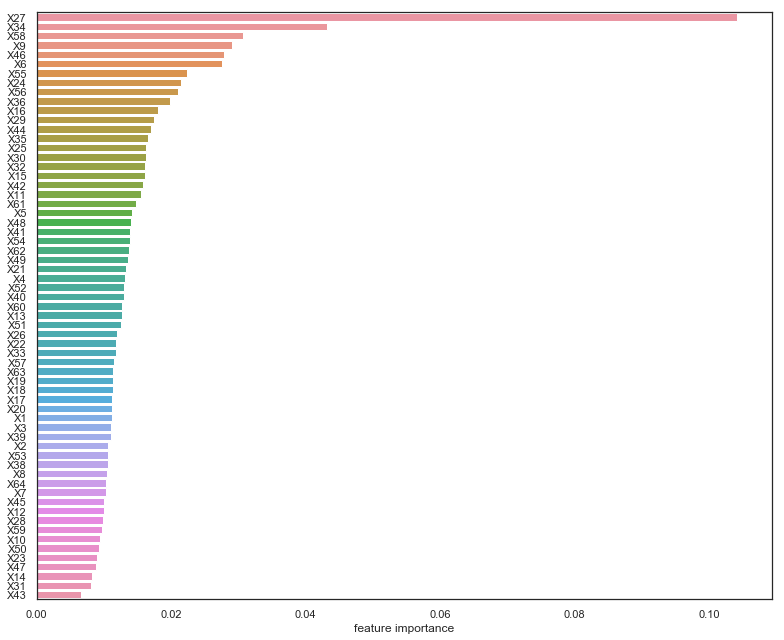

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf_1 = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print('Training done using Random Forest')
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [38]:
cols = X_train.columns.values[ranking][0:3]
X_1 = all_data[cols]


,X27,X34,X58
0,1.45820,0.56393,0.87804
1,88.44400,2.98760,0.85300
2,86.01100,1.42740,0.76599
3,0.94076,0.37581,0.94598
4,1.41380,0.32340,0.86515


スタッキングを実装

In [25]:
rf = RandomForestClassifier()
gb =GradientBoostingClassifier()
nn = MLPClassifier(max_iter=10000)
ab = AdaBoostClassifier()
logi = LogisticRegression()

ensemble_clf=[rf,gb, nn, ab, logi] 
params = {     
      'n_estimators'      : [10],
      'max_features'      :[0.1,1.0]}
for i in range(len(ensemble_clf)):
    Grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=params, 
                      n_jobs=-1, cv=3, verbose=3).fit(X_train, y_train)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] max_features=0.1, n_estimators=10 ...............................
[CV] max_features=0.1, n_estimators=10 ...............................
[CV] max_features=0.1, n_estimators=10 ...............................
[CV] max_features=1.0, n_estimators=10 ...............................
[CV]  max_features=0.1, n_estimators=10, score=0.9848726962820923, total=   2.5s
[CV] max_features=1.0, n_estimators=10 ...............................
[CV]  max_features=0.1, n_estimators=10, score=0.9862575902844359, total=   2.6s
[CV] max_features=1.0, n_estimators=10 ...............................
[CV]  max_features=0.1, n_estimators=10, score=0.9858284496537028, total=   2.7s


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    2.9s remaining:    5.9s


[CV]  max_features=1.0, n_estimators=10, score=0.989346969212741, total=  24.6s
[CV]  max_features=1.0, n_estimators=10, score=0.9884922749067662, total=  23.8s
[CV]  max_features=1.0, n_estimators=10, score=0.9896665601363588, total=  24.3s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   27.1s finished


In [39]:
pred = Grid.predict(test_X)
pred

array([0, 0, 0, ..., 0, 0, 0])

ok

rf = RandomForestClassifier()
gb =GradientBoostingClassifier()
nn = MLPClassifier(max_iter=10000)
ab = AdaBoostClassifier()
logi = LogisticRegression()

ensemble_clf=[rf, gb, nn, ab, logi] 
params = {     
      'n_estimators'      : [10],
      'max_features'      :[0.1,1.0]}
for i in range(len(ensemble_clf)):
    Grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=params, 
                      n_jobs=-1, cv=3, verbose=3).fit(X_train, y_train)


In [325]:
from sklearn.linear_model import LogisticRegression
models = {
    ("RandomForest", RandomForestClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("NeuralNetwork", MLPClassifier(max_iter = 10000,)),
    ("AdaBoost", AdaBoostClassifier())
    }
for name, model in models:
    acc = accuracy_score(y_test, model.fit(X_train, y_train).predict(X_test))
    print("Accuracy of", name, ":", acc)

In [ ]:
from sklearn.ensemble import StackingClassifier
acc = accuracy_score(y_test, stacking.fit(X_train, y_train).predict(X_test))
print("Accuracy of Stacking :", acc)

csvに出力

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'TARGET': pred})
submission.to_csv('submission.csv', index=False)